## Introduction

Below is our exploratory data analysis of users of the hypothetical InterConnect internet and phone service. The first two dataframes contain user contract and personal information, while the latter two dataframes contain internet and phone service option data. Some of these users have a date on which they discontinued service (churned). All other users are active as of the pulling of the data, on February 1, 2020.

The business has expressed an interest in identifying users who are about to churn. InterConnect could then offer incentives and discounts. To accomplish this task, we can build a machine learning model that can profile users and identify likely churn candidates.

Before we build a model, we should clean the data contained in the source CSVs, create useful features to feed into the model, and explore the data to understand the distribution of -- and relationships between -- features. This notebook contains only that exploratory analysis, and some target questions to consider thereafter. We will conclude with a full plan for building our ideal model.

## Initializing

In [1]:
# Loading all base libraries
import pandas as pd
from scipy import stats as st
import numpy as np

In [2]:
# Read the CSVs into dataframes
df_contracts_raw = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal_raw = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet_raw = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone_raw = pd.read_csv('/datasets/final_provider/phone.csv')

## Pre-processing

This is our opportunity to check for missing values and duplicates, and then to generate new values and features before entering the domain of statistics.

### Contracts

This is the dataframe for user information, which also contains the target for our task: whether a user has churned is captured in the 'EndDate' column.

In [3]:
# Make a copy to preserve original data
df_contracts = df_contracts_raw.copy()

# Quick view
df_contracts.info()
df_contracts.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1128,0098-BOWSO,2017-11-01,No,Month-to-month,Yes,Electronic check,19.40,529.8
2875,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7
1783,8380-PEFPE,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,71.65,71.65
3804,9773-PEQBZ,2019-04-01,No,Month-to-month,No,Electronic check,79.85,797.25
6087,8319-QBEHW,2017-12-01,No,One year,Yes,Bank transfer (automatic),39.95,1023.75
2071,3392-EHMNK,2014-07-01,No,Two year,No,Credit card (automatic),94.10,6302.8
2395,6486-LHTMA,2017-07-01,No,One year,Yes,Electronic check,90.70,2835.5
4660,0883-EIBTI,2019-10-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,19.50,31.55
372,6122-EFVKN,2018-02-01,No,Two year,No,Mailed check,35.75,830.8
1143,2446-ZKVAF,2018-08-01,No,Month-to-month,No,Credit card (automatic),56.80,1074.65


Since 'TotalCharges' appears as an object type and not a float64 as the 'MonthlyCharges' feature is, we can assume there are values tripping up its correct processing. We should investigate. Additionally, 'PaperlessBilling' is more useful as a bool. 

In [4]:
# Make 'PaperlessBilling' a bool
df_contracts['PaperlessBilling'] = df_contracts['PaperlessBilling'] == 'Yes'

In [5]:
# Convert TotalCharges to a float
df_contracts['TotalCharges'] = pd.to_numeric(df_contracts['TotalCharges'], errors='coerce')

# Check our work
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   bool   
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: bool(1), float64(2), object(5)
memory usage: 392.2+ KB


In [6]:
# Investigate the 11 null values for TotalCharges
display(df_contracts[df_contracts['TotalCharges'].isna()])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,True,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,False,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,False,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,False,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,False,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,False,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,False,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,False,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,True,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,False,Mailed check,73.35,NaN


These customers joined on 2020-02-01, which is the same day that the data was pulled. This means they have not yet paid a bill as they are fresh customers. We can safely replace the NaN values with 0s since they have, in fact, paid $0.

Then we will check for duplicates and remove extraneous columns.

In [7]:
# Replace NaNs with 0s
df_contracts['TotalCharges'] = df_contracts['TotalCharges'].fillna(0)

In [8]:
# Check for duplicates
display(df_contracts[df_contracts.duplicated()])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


There are no duplicate entries or extraneous columns. The 'columnID' is not useful for ML training but is required to align with user info in the other dataframes.

The original data was pulled on Feb 1, 2020, so we can treat 2020-02-01 as the datetime value of the "current" time. Subtracting the datetime value from their contract beginning will give the measure of how long they have been a customer.

We should first create a new column 'Churned' which will become our target column before modifying the 'EndDate' column.

In [9]:
# NEW column 'Churned' (type: bool)
df_contracts['Churned'] = df_contracts['EndDate'] != 'No'

display(df_contracts[['EndDate', 'Churned']].sample(10, random_state=12345))

,EndDate,Churned
1128,No,False
2875,2019-12-01 00:00:00,True
1783,2019-10-01 00:00:00,True
3804,No,False
6087,No,False
2071,No,False
2395,No,False
4660,2019-12-01 00:00:00,True
372,No,False
1143,No,False


In [10]:
# Column 'BeginDate' can garner for us a measure of how long they have been a customer, which is very valuable. 
# First we should replace all 'No' values with the date of pulling the data, which is 2020-02-01
df_contracts['EndDate'] = df_contracts['EndDate'].where(df_contracts['EndDate'] != 'No', '2020-02-01')

We are ready to create new datetime features. Machine learning models cannot process datetime values, so we will use the datetime type for some useful math when creating a few new features.

We will create two new features via datetime math: 'DaysCustomer', which reflects the number of days a user was/is a customer, and 'ChurnSeasonality', which assigns a value from -1 to 1 on whether a user churned in a similar or dissimilar time of year as they signed up. Using a cosine function on the remainder of the division of 'DaysCustomer' by 365.25 (accounting for leap years) yields this function.

The year of past users' churning is irrelevant to training a model in our task of determining whether a current active user will churn. The length of a user being active is now captured in a new feature, so we can afford to drop the 'BeginDate' and 'EndDate' columns.

In [11]:
# Then we can convert both columns to datetime, dropping time values
df_contracts['BeginDate'] = pd.to_datetime(df_contracts['BeginDate'], format='%Y-%m-%d')
df_contracts['EndDate'] = pd.to_datetime(df_contracts['EndDate'], format='%Y-%m-%d')

# NEW column 'DaysCustomer' (type: float64)
df_contracts['DaysCustomer'] = df_contracts['EndDate'] - df_contracts['BeginDate']
df_contracts['DaysCustomer'] = pd.to_numeric(df_contracts['DaysCustomer'].dt.days)

# NEW column 'ChurnSeasonality' (type: float64)
df_contracts['ChurnSeasonality'] = np.cos(2 * np.pi * (df_contracts['DaysCustomer'] % 365.25) / 365.25)

# DROP columns 'BeginDate' and 'EndDate'
df_contracts = df_contracts.drop(['BeginDate', 'EndDate'], axis=1)

In [12]:
# Final check against the above before moving on
df_contracts.info()
df_contracts.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
dtypes: bool(2), float64(3), int64(1), object(3)
memory usage: 399.0+ KB


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,DaysCustomer,ChurnSeasonality
1128,0098-BOWSO,Month-to-month,True,Electronic check,19.40,529.80,False,822,-0.003225
2875,9992-RRAMN,Month-to-month,True,Electronic check,85.10,1873.70,True,668,0.475599
1783,8380-PEFPE,Month-to-month,True,Electronic check,71.65,71.65,True,30,0.869764
3804,9773-PEQBZ,Month-to-month,False,Electronic check,79.85,797.25,False,306,0.524010
6087,8319-QBEHW,One year,True,Bank transfer (automatic),39.95,1023.75,False,792,0.490660
2071,3392-EHMNK,Two year,False,Credit card (automatic),94.10,6302.80,False,2041,-0.851148
2395,6486-LHTMA,One year,True,Electronic check,90.70,2835.50,False,945,-0.853398
4660,0883-EIBTI,Month-to-month,False,Mailed check,19.50,31.55,True,61,0.498137
372,6122-EFVKN,Two year,False,Mailed check,35.75,830.80,False,730,0.999963
1143,2446-ZKVAF,Month-to-month,False,Credit card (automatic),56.80,1074.65,False,549,-0.999813


### Personal

This is the dataframe with personal information about users, beyond their plan and payment information above. This can be a helpful dataset to classify user backgrounds.

In [13]:
# Make a copy to preserve original data
df_personal = df_personal_raw.copy()

# Quick view
df_personal.info()
display(df_personal.sample(10, random_state=12345))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
1128,0098-BOWSO,Male,0,No,No
2875,9992-RRAMN,Male,0,Yes,No
1783,8380-PEFPE,Male,0,No,Yes
3804,9773-PEQBZ,Male,0,No,No
6087,8319-QBEHW,Male,0,No,Yes
2071,3392-EHMNK,Female,0,Yes,Yes
2395,6486-LHTMA,Female,1,Yes,No
4660,0883-EIBTI,Female,0,No,No
372,6122-EFVKN,Male,0,No,Yes
1143,2446-ZKVAF,Male,0,Yes,No


'SeniorCitizen', 'Partner' and 'Dependents' work best as boolean values for efficiency. We should confirm whether the 'gender' column is also a binary classification in this dataset, and if so, convert that to boolean.

In [14]:
display(df_personal['gender'].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64

In [15]:
# Make all bool
df_personal['gender'] = df_personal['gender'] == 'Female'
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'] == '1'
df_personal['Partner'] = df_personal['Partner'] == 'Yes'
df_personal['Dependents'] = df_personal['Dependents'] == 'Yes'

# Check our work against the above
display(df_personal.sample(10, random_state=12345))

,customerID,gender,SeniorCitizen,Partner,Dependents
1128,0098-BOWSO,False,False,False,False
2875,9992-RRAMN,False,False,True,False
1783,8380-PEFPE,False,False,False,True
3804,9773-PEQBZ,False,False,False,False
6087,8319-QBEHW,False,False,False,True
2071,3392-EHMNK,True,False,True,True
2395,6486-LHTMA,True,False,True,False
4660,0883-EIBTI,True,False,False,False
372,6122-EFVKN,False,False,False,True
1143,2446-ZKVAF,False,False,True,False


### Internet

This is the dataframe demonstrating the internet options users take.

In [16]:
# Make a copy to preserve original data
df_internet = df_internet_raw.copy()

# Quick view
df_internet.info()
df_internet.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4878,7823-JSOAG,Fiber optic,No,No,No,No,No,No
5002,4450-YOOHP,DSL,No,No,Yes,No,Yes,Yes
4160,2498-XLDZR,DSL,Yes,Yes,Yes,Yes,No,Yes
683,7905-TVXTA,DSL,Yes,No,No,Yes,Yes,No
1930,9802-CAQUT,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
2140,3387-VATUS,Fiber optic,No,No,No,No,Yes,Yes
2311,2845-AFFTX,Fiber optic,No,No,Yes,No,Yes,Yes
3417,0853-NWIFK,Fiber optic,Yes,Yes,No,No,Yes,Yes
1472,0973-KYVNF,DSL,Yes,Yes,Yes,No,Yes,No
4716,9253-QXKBE,Fiber optic,No,No,No,No,Yes,Yes


In [17]:
# Check for categories on InternetService
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [18]:
# Convert all to bool for efficient procesing
df_internet['InternetService'] = df_internet['InternetService'] == 'Fiber optic'
yesno_list = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in yesno_list:
    df_internet[col] = df_internet[col] == 'Yes'

In [19]:
# Check for duplicates
display(df_internet[df_internet.duplicated()])

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


There are no duplicates and all features have been cleaned.

In [20]:
# Show our work 
display(df_internet.sample(10, random_state=12345))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4878,7823-JSOAG,True,False,False,False,False,False,False
5002,4450-YOOHP,False,False,False,True,False,True,True
4160,2498-XLDZR,False,True,True,True,True,False,True
683,7905-TVXTA,False,True,False,False,True,True,False
1930,9802-CAQUT,True,True,True,True,False,True,True
2140,3387-VATUS,True,False,False,False,False,True,True
2311,2845-AFFTX,True,False,False,True,False,True,True
3417,0853-NWIFK,True,True,True,False,False,True,True
1472,0973-KYVNF,False,True,True,True,False,True,False
4716,9253-QXKBE,True,False,False,False,False,True,True


The first two dataframes have 7,043 rows, but the internet dataframe has 5,517 rows. This is presumably due to some users' lack of utilization of internet services.

### Phone

This is the dataframe demonstrating the phone options users take.

In [21]:
# Make a copy to preserve original data
df_phone = df_phone_raw.copy()

# Quick view
df_phone.info()
df_phone.sample(10, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
1649,8966-KZXXA,Yes
1920,7206-PQBBZ,No
2852,4567-AKPIA,Yes
911,7047-YXDMZ,No
6259,7619-PLRLP,Yes
3581,1304-NECVQ,Yes
5992,9248-OJYKK,Yes
3169,2921-XWDJH,No
3903,9134-WYRVP,No
121,3774-VBNXY,No


In [22]:
# Make bool
df_phone['MultipleLines'] = df_phone['MultipleLines'] == 'Yes'

In [23]:
# Check for duplicates
display(df_phone[df_phone.duplicated()])

,customerID,MultipleLines


There are no duplicates and all features have been cleaned.

In [24]:
# Check our work
display(df_phone.sample(10, random_state=12345))

,customerID,MultipleLines
1649,8966-KZXXA,True
1920,7206-PQBBZ,False
2852,4567-AKPIA,True
911,7047-YXDMZ,False
6259,7619-PLRLP,True
3581,1304-NECVQ,True
5992,9248-OJYKK,True
3169,2921-XWDJH,False
3903,9134-WYRVP,False
121,3774-VBNXY,False


As with the internet dataframe, the phone dataframe contains fewer rows (6,361) than the total users (7,043), suggesting not all users utilize phone plans.

### Merge Data to Master Dataframe

Our goal here is to merge all the dataframes without dropping any users. This will require using three outer merges, which fill missing matches with NaNs. Luckily, the df_internet and df_phone dataframes only contain bool columns, so filling the NaN values will be trivial.

In [25]:
# Successive merges onto dataframe
df = df_contracts.merge(df_personal, on='customerID', how='outer')
df = df.merge(df_internet, on='customerID', how='outer')
df = df.merge(df_phone, on='customerID', how='outer')

# Check our work
df.info()
df.sample(20, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
 9   gender            7043 non-null   bool   
 10  SeniorCitizen     7043 non-null   bool   
 11  Partner           7043 non-null   bool   
 12  Dependents        7043 non-null   bool   
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,DaysCustomer,ChurnSeasonality,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1128,0098-BOWSO,Month-to-month,True,Electronic check,19.40,529.80,False,822,-0.003225,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2875,9992-RRAMN,Month-to-month,True,Electronic check,85.10,1873.70,True,668,0.475599,False,...,True,False,True,False,False,False,False,False,True,True
1783,8380-PEFPE,Month-to-month,True,Electronic check,71.65,71.65,True,30,0.869764,False,...,False,True,True,False,False,False,False,False,False,False
3804,9773-PEQBZ,Month-to-month,False,Electronic check,79.85,797.25,False,306,0.524010,False,...,False,False,True,False,True,False,False,False,False,True
6087,8319-QBEHW,One year,True,Bank transfer (automatic),39.95,1023.75,False,792,0.490660,False,...,False,True,False,False,True,False,False,True,False,NaN
2071,3392-EHMNK,Two year,False,Credit card (automatic),94.10,6302.80,False,2041,-0.851148,True,...,True,True,True,False,True,False,True,True,False,True
2395,6486-LHTMA,One year,True,Electronic check,90.70,2835.50,False,945,-0.853398,True,...,True,False,True,False,False,True,False,True,False,True
4660,0883-EIBTI,Month-to-month,False,Mailed check,19.50,31.55,True,61,0.498137,True,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
372,6122-EFVKN,Two year,False,Mailed check,35.75,830.80,False,730,0.999963,False,...,False,True,False,True,False,False,True,False,False,NaN
1143,2446-ZKVAF,Month-to-month,False,Credit card (automatic),56.80,1074.65,False,549,-0.999813,False,...,True,False,False,False,True,False,False,False,False,True


We know that all NaN values come originally from the df_internet and df_phone dataframes, which indicate that the user doesn't have any part of that service. It is valuable information that a user doesn't have an entire service category (or, more accurately, it is valuable information that a user has one or two service categories). 

We can create two new features to reflect whether a user is included in the df_internet and df_phone dataframes, respectively. Then we can fill all the NaN values with False.

In [26]:
# Two NEW features for whether user has Internet and whether user has Phone service (type: bool)
df['HasInternet'] = ~df[yesno_list].isna().any(axis=1) # yesno_list taken from above: col names from df_internet
df['HasPhone'] = ~df['MultipleLines'].isna()

In [27]:
# Replace all NaN values (meaning the customer doesn't have that service) with False to preserve data type as bool
df = df.fillna(False)

In [28]:
# Check our work
df.info()
df.sample(20, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   bool   
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   bool   
 7   DaysCustomer      7043 non-null   int64  
 8   ChurnSeasonality  7043 non-null   float64
 9   gender            7043 non-null   bool   
 10  SeniorCitizen     7043 non-null   bool   
 11  Partner           7043 non-null   bool   
 12  Dependents        7043 non-null   bool   
 13  InternetService   7043 non-null   bool   
 14  OnlineSecurity    7043 non-null   bool   
 15  OnlineBackup      7043 non-null   bool   
 16  DeviceProtection  7043 non-null   bool   


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,DaysCustomer,ChurnSeasonality,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,HasInternet,HasPhone
1128,0098-BOWSO,Month-to-month,True,Electronic check,19.40,529.80,False,822,-0.003225,False,...,False,False,False,False,False,False,False,False,False,True
2875,9992-RRAMN,Month-to-month,True,Electronic check,85.10,1873.70,True,668,0.475599,False,...,True,False,False,False,False,False,True,True,True,True
1783,8380-PEFPE,Month-to-month,True,Electronic check,71.65,71.65,True,30,0.869764,False,...,True,False,False,False,False,False,False,False,True,True
3804,9773-PEQBZ,Month-to-month,False,Electronic check,79.85,797.25,False,306,0.524010,False,...,True,False,True,False,False,False,False,True,True,True
6087,8319-QBEHW,One year,True,Bank transfer (automatic),39.95,1023.75,False,792,0.490660,False,...,False,False,True,False,False,True,False,False,True,False
2071,3392-EHMNK,Two year,False,Credit card (automatic),94.10,6302.80,False,2041,-0.851148,True,...,True,False,True,False,True,True,False,True,True,True
2395,6486-LHTMA,One year,True,Electronic check,90.70,2835.50,False,945,-0.853398,True,...,True,False,False,True,False,True,False,True,True,True
4660,0883-EIBTI,Month-to-month,False,Mailed check,19.50,31.55,True,61,0.498137,True,...,False,False,False,False,False,False,False,False,False,True
372,6122-EFVKN,Two year,False,Mailed check,35.75,830.80,False,730,0.999963,False,...,False,True,False,False,True,False,False,False,True,False
1143,2446-ZKVAF,Month-to-month,False,Credit card (automatic),56.80,1074.65,False,549,-0.999813,False,...,False,False,True,False,False,False,False,True,True,True


## Exploratory Data Analysis

### Init

In [29]:
# Graphing libraries
import plotly.express as px
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter as pf
import seaborn as sns

### Examine Quantitative Feature Distributions

We can first look at the distributions of four numeric features: monthly charges, total charges, churn date against start date seasonality, and the total days users have been customers. We'll look at the same pairplot distribution graphs with three different categories to color the distributions: user contract type, payment type, and our target feature -- whether users have discontinued service (churned).

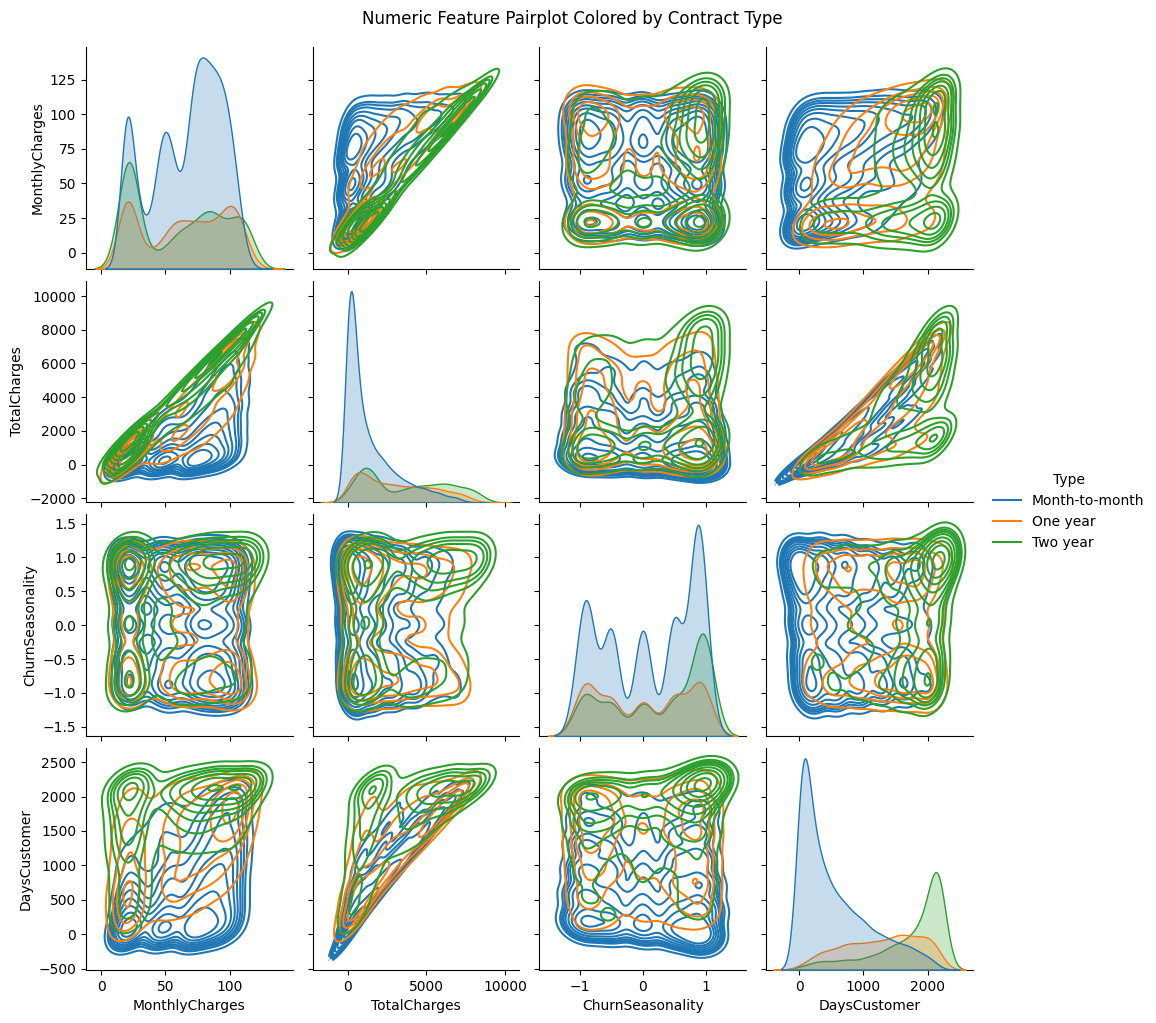

In [30]:
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'ChurnSeasonality', 'DaysCustomer']
pp = sns.pairplot(df[['Type'] + numeric_cols], kind='kde', hue='Type')
pp.fig.suptitle("Numeric Feature Pairplot Colored by Contract Type", y=1.02)
plt.show()

The first item to note is that there are more total month-to-month users. Looking at the final graph (bottom right), among users who are have not been customers for long, they are overwhelmingly month-to-month, indicating most users in 2020 are beginning their service as month-to-month users. The considerable left-skew of the two-year contract users indicates that newer users are not favoring two-year contracts.

Month-to-month users, however, are rather evenly distibuted in the 'MonthlyCharges' features. In fact, none of the contract types are especially left- or right-distributted despite all having local peaks at $25.

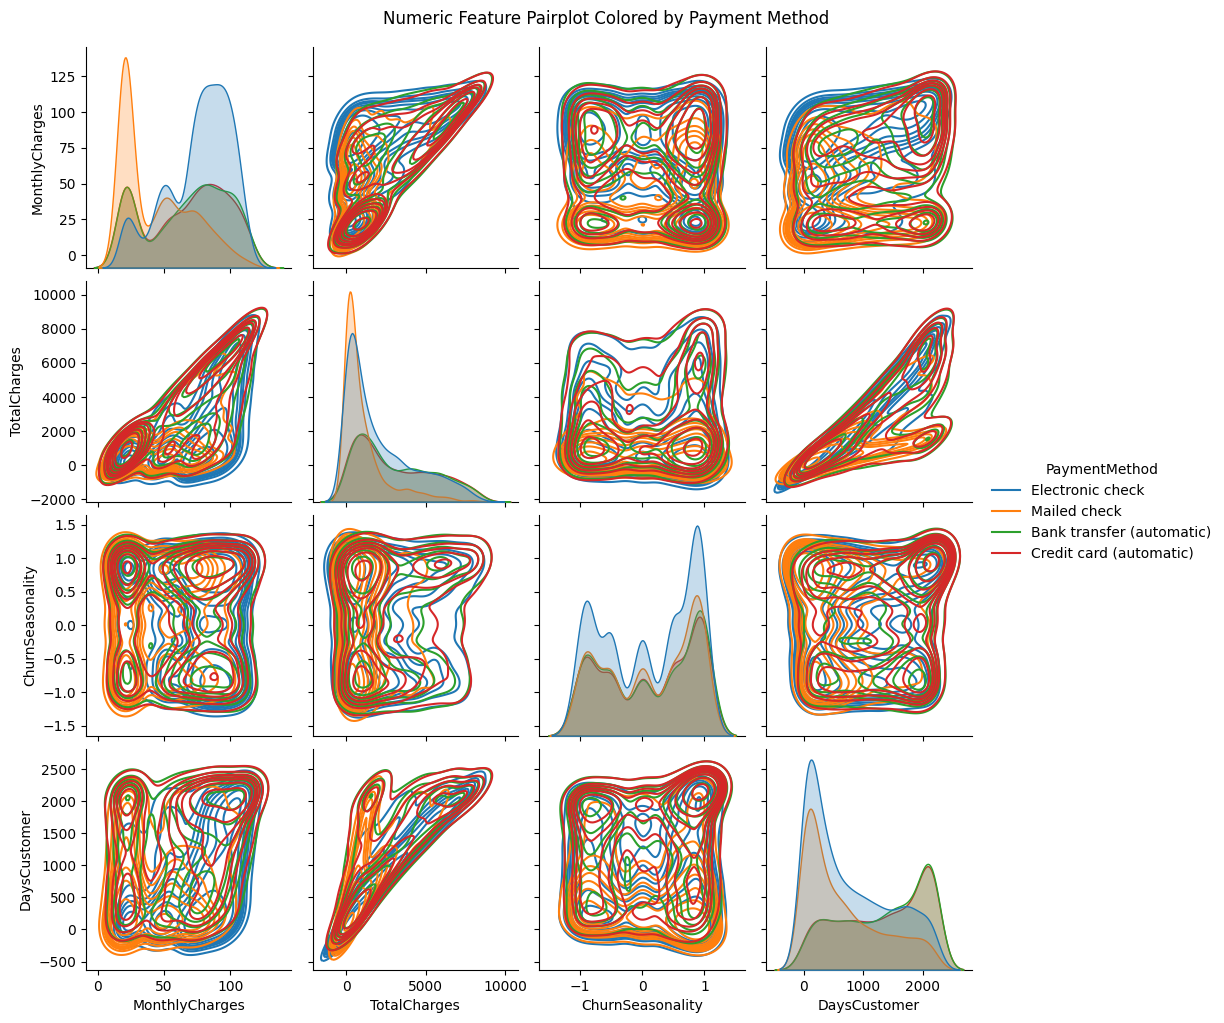

In [31]:
pp = sns.pairplot(df[['PaymentMethod'] + numeric_cols], kind='kde', hue='PaymentMethod')
pp.fig.suptitle("Numeric Feature Pairplot Colored by Payment Method", y=1.02)
plt.show()

The first graph gives us two obvious peaks: low monthly charges around the 25 dollar mark are dominated by mailed check delivery methods, and high monthly charges around the 90 dollar mark are dominated by electronic checks. Mailed check delivery has a significant right skew, and electronic checks have a significant left skew in the monthly charge graph. However, perhaps surprisingly, both of these methods dominate users who had low *total* charges (graph 5, or second row second graph) and thus low days as a customer (last graph, on the bottom right). Among the month-to-month users who dominate the low 'DaysCustomer' value range (demonstrated by the prior section of pairplot analysis) users are far more likely to use electronic checks or mailed checks.

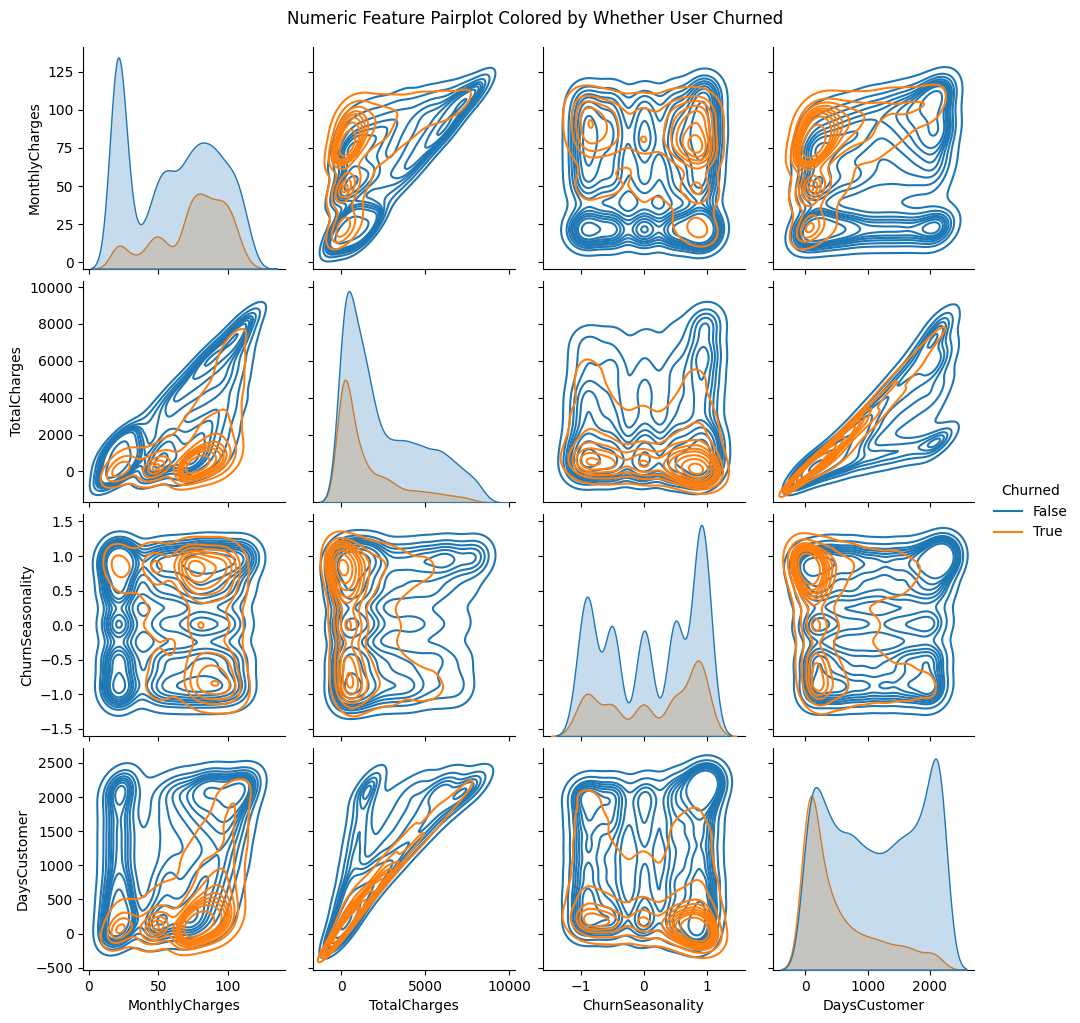

In [32]:
pp = sns.pairplot(df[['Churned'] + numeric_cols], kind='kde', hue='Churned')
pp.fig.suptitle("Numeric Feature Pairplot Colored by Whether User Churned", y=1.02)
plt.show()

The beauty of the KDE distribution plots are perceiving the hotspots. Given that the distribution of the 'DaysCustomer' indicates a severe right skew of users who churned, we can safely conclude that the target user at risk of churning has not been a customer for terribly long. However, looking at the sixteenth graph, users who have been customers for less than a single year are almost equally likely to churn versus not. We need more information to delineate user churn risk.

Looking at the eighth graph (last graph on the second row), it is clear that as users who are likely to churn continue to rack up InterConnect charges, those charges tend to be of high values, creating a very linear relationship between 'DaysCustomer' and 'TotalCharges.' Look at the very first graph -- there are peaks at high monthly charges (around 80 dollars) for both users who churn and who don't churn. However, there is a significant peak for users who didn't churn at about the 25 dollar mark that is barely present for users who did churn. The conclusion here is that users who churn tend to pay much higher monthly charges all the way until they churn. Based on the fourth graph, if a user has been a customer for longer than about two years, the only users who churn are those with high monthly charges.

### Examine Categorical Feature Distributions Against Target Feature

In [33]:
# We'll plot the categorical variables now.
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Churned', 'gender', \
            'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', \
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', \
            'MultipleLines', 'HasInternet', 'HasPhone']
df['NotChurned'] = df['Churned'] == False

def label_axes(ax, i, feature):
    ax.set_title((f"{i+1}. {feature}"))
    ax.set_ylabel('# Users')
    ax.set_xlabel('')
    if feature=='PaymentMethod':
        xlabels = ['Bank', 'Credit', 'ECheck', 'Mail']
    else:
        xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation=0)
    ax.get_legend().remove()
    
def add_counts(ax, data):
    for rownum in range(0, len(data)):
        ax.text(rownum, data.iloc[rownum]['NotChurned'], f"{data.iloc[rownum]['NotChurned']}", fontsize='small', ha='right')
        ax.text(rownum, data.iloc[rownum]['Churned'], f"{data.iloc[rownum]['Churned']}", fontsize='small', ha='left')

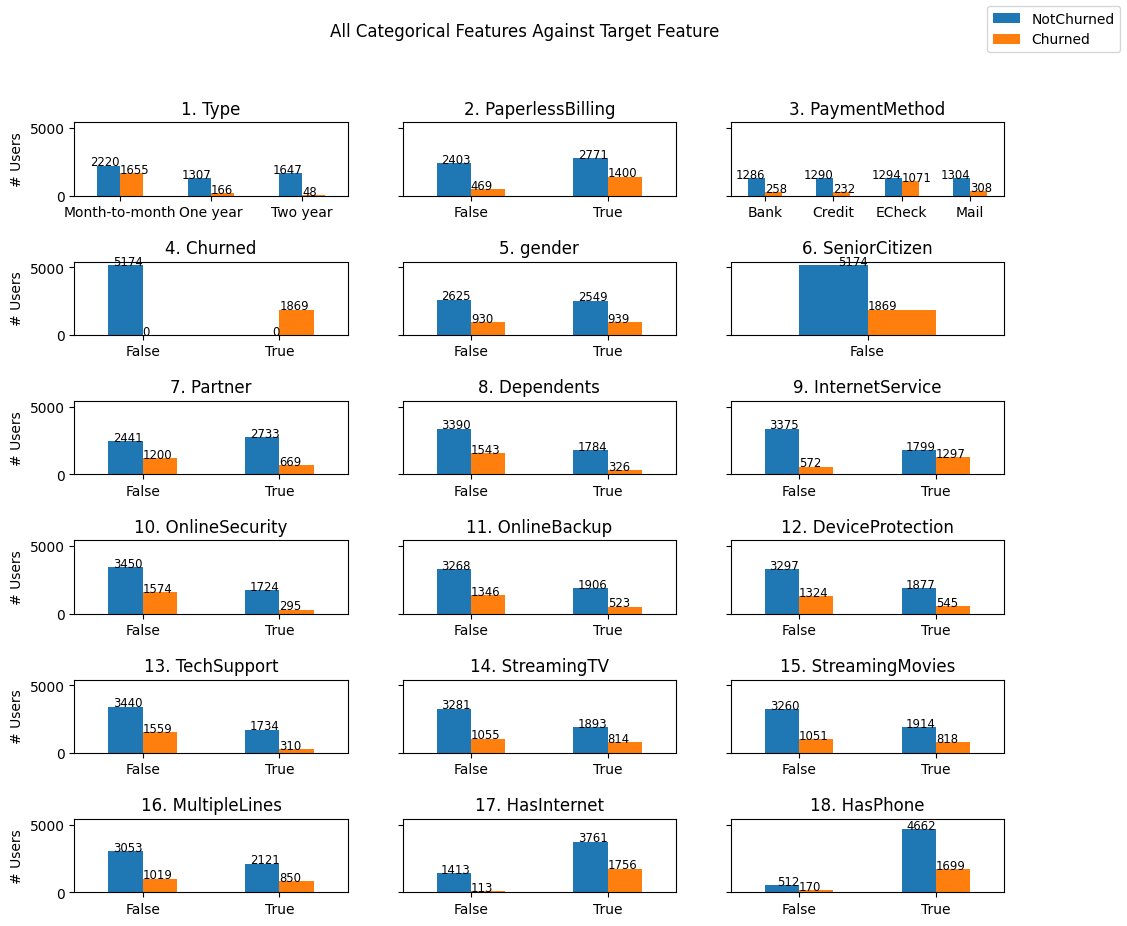

In [34]:
fig, axes = plt.subplots(6, 3, figsize=(12, 10), sharey=True, squeeze=False)

i = -1
for r in range(0, 6):
    for c in range(0, 3):
        i += 1
        feature = cat_cols[i]
        plotsum = df.groupby(feature)[['NotChurned', 'Churned']].sum()
        plotsum.plot(
            kind='bar', ax=axes[r, c]
        )
        label_axes(axes[r, c], i, feature)
        add_counts(axes[r, c], plotsum) 
plt.suptitle('All Categorical Features Against Target Feature')
fig.legend(['NotChurned', 'Churned'])
plt.subplots_adjust(hspace=0.9)
plt.show()

Laying out these features in such a brutalist, straightforward way allows us to make clear and obvious statements about how these categorical features interact with our target feature 'Churned'. 

Our fourth graph shows our class imbalance in our target feature of about 5:2. We should therefore treat upsampling, downsampling, or weighting classes as potential solutions to improve model performance if our model struggles.

Our first graph shows a clear demonstration of what has caused the right skew of month-to-month users in 'DaysCustomer': the users churn. Almost all churning users are on a month-to-month contract.

In the quantitative analysis section we found that ECheck and Mailed Check users tended to not be customers for long, with the former having high monthly charges and the latter having lower monthly charges. We also have a split in our target feature here: users who churned are over three times more likely to use Echecks than Mailed Checks.

The 'SeniorCitizen' feature contains False values for all users so it can be dropped.

Very starkly, users who did not appear on the df_internet dataframe (graph 17) were 14 times more likely not to churn.

Churning users were also:
- Three times more likely to use paperless billing (graph 2)
- Four times more likely to have no dependents (graph 8)
- Five times more likely not to use online security (graph 10)
- Five times more likely not to use technical support (graph 13)

In [35]:
# Our final line of code will be to drop the 'SeniorCitizen' feature
df = df.drop('SeniorCitizen', axis=1)

## Conclusions

The profile of a typical user who churns is one who has higher monthly charges, racks them up via ECheck charges without signing onto a one- or two-year plan, and then churns within the first two years of service. They did not use technical support, electronic billing, or most of the internet service options. They have no kids and tend to be without a partner.

### Questions

Clarifying questions for the upcoming training of the model include:

- Should we address the target feature class imbalance of 5:2?
- Are there any categorical features that can be encoded to reflect a somewhat quantitative number? We could encode the contract feature, for example to be 0, 1, and 2 to reflect month-to-month, one-year, and two-year contracts. However, since one-year and two-year contract data is very similar, and given a value of 0 is significant in model internal algorithms, it may make more sense to encode them as something like 1, 5, and 7.
- The model selection should be robust enough to make powerful predictions but lean enough for ipynb kernels. We can afford to use GridSearch to tune the hyperparameters, but does this data merit more processing power outside of the notebook?
- What degree and manner of gradient boosting should be executed? We have not previously gradient boosted on classification tasks, so some experimentation could be required, but some research suggests that given the number of boolean features we have, gradient boosting could be required to optimize the model.

### Next Steps

- **PREP DATA** | We will still have to do some prepping of data before moving into the land of modelling. We will want to encode categorical features, change all quantitative features to lie in the range of 0 to 1, and then split the data into training, validation, and test sets (since we will be tuning hyperparameters).

- **TRAIN MODELS** | We will train classification models with a grid search pipeline with f1_score as the target evaluation metric. We will try various models including RandomForestClassifier and some KNN-based cluster algorithms.

- **ANALYZE MODELS** | Our goal for the task is to achieve the best AUC-ROC score for our model. We will therefore chart the best-performing models and analyze some sample inputs and predictions to understand their strengths and weaknesses.

- **TUNE MODELS** | We will attempt various tuning methods on our best models and finally arrive at our ideal model. Tuning may consist of gradient boosting, class weight/imbalance fixes, and changes to encoding methods.

- **CONCLUSIONS AND BEST MODEL** | The best model from the last step will be measured and submitted as the final model, and we will make some conclusions based on what we have observed.